In [1]:
from keras.models import *
from keras.layers import *
import keras

Using TensorFlow backend.


In [2]:
import numpy as np                        # ndarrys for gridded data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import seaborn as sns                     # for plotting
import warnings                           # supress warnings from seaborn pairplot
import cv2 
import random
import tensorflow as tf
import keras.backend as K
from keras.utils import to_categorical
import glob
import keras
from PIL import Image
import json
import os
import gc
from tqdm import notebook, tnrange
import tifffile as tiff
from sklearn.model_selection import train_test_split
import time
import datetime
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [3]:
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2, name: TITAN Xp, pci bus id: 0000:83:00.0, compute capability: 6.1



In [4]:
os.chdir("/home/ahadmomin/project")

In [5]:
def iou_loss(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def iou(y_true, y_pred, label: int):
    """
    Return the Intersection over Union (IoU) for a given label.
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
        label: the label to return the IoU for
    Returns:
        the IoU for the given label
    """
    # extract the label values using the argmax operator then
    # calculate equality of the predictions and truths to the label
    y_true = K.cast(K.equal(K.argmax(y_true), label), K.floatx())
    y_pred = K.cast(K.equal(K.argmax(y_pred), label), K.floatx())
    # calculate the |intersection| (AND) of the labels
    intersection = K.sum(y_true * y_pred)
    # calculate the |union| (OR) of the labels
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    # avoid divide by zero - if the union is zero, return 1
    # otherwise, return the intersection over union
    return K.switch(K.equal(union, 0), 1.0, intersection / union)


def build_iou_for(label: int, name: str=None):
    """
    Build an Intersection over Union (IoU) metric for a label.
    Args:
        label: the label to build the IoU metric for
        name: an optional name for debugging the built method
    Returns:
        a keras metric to evaluate IoU for the given label
        
    Note:
        label and name support list inputs for multiple labels
    """
    # handle recursive inputs (e.g. a list of labels and names)
    if isinstance(label, list):
        if isinstance(name, list):
            return [build_iou_for(l, n) for (l, n) in zip(label, name)]
        return [build_iou_for(l) for l in label]

    # build the method for returning the IoU of the given label
    def label_iou(y_true, y_pred):
        """
        Return the Intersection over Union (IoU) score for {0}.
        Args:
            y_true: the expected y values as a one-hot
            y_pred: the predicted y values as a one-hot or softmax output
        Returns:
            the scalar IoU value for the given label ({0})
        """.format(label)
        return iou(y_true, y_pred, label)

    # if no name is provided, us the label
    if name is None:
        name = label
    # change the name of the method for debugging
    label_iou.__name__ = 'iou_{}'.format(name)

    return label_iou
        

def mean_iou(y_true, y_pred):
    """
    Return the Intersection over Union (IoU) score.
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
    Returns:
        the scalar IoU value (mean over all labels)
    """
    # get number of labels to calculate IoU for
    num_labels = K.int_shape(y_pred)[-1]
    # initialize a variable to store total IoU in
    total_iou = K.variable(0)
    # iterate over labels to calculate IoU for
    for label in range(num_labels):
        total_iou = total_iou + iou(y_true, y_pred, label)
    # divide total IoU by number of labels to get mean IoU
    return total_iou / num_labels


smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [6]:
num_gpus =3
total_samples=2400
batch_size=6
epochs =50
train_ids = np.arange(0, total_samples)
image_dims = (512,512)
filters_first_layer = 64
## Validation Data Size
val_data_size = 263
validation_split=0.2
file_loc= 'train_numpy/'

In [7]:
all_dirs = glob.glob(file_loc + '/X/*.npy')

X_train = np.zeros((len(all_dirs),image_dims[0],image_dims[1],3)).astype(np.float32)
y_train = np.zeros((len(all_dirs),image_dims[0],image_dims[1],4)).astype(np.int8)

for im_num in notebook.tqdm(range( len(all_dirs) )):
    
    X_train[im_num,:,:,:] = np.load( file_loc + f'/X/{im_num}.npy' )
    y_train[im_num,:,:,:] = np.load( file_loc + f'/y/{im_num}.npy' )

Text(0.5, 1.0, 'Segmented(GR)')

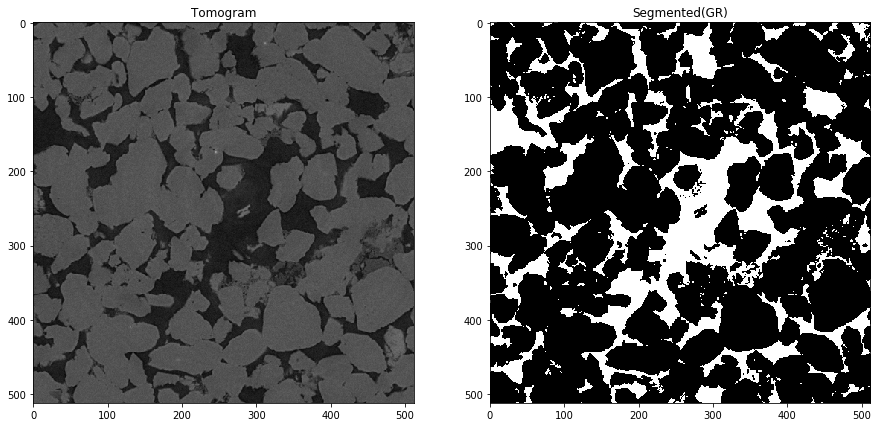

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))
ax1.imshow(X_train[3].astype('float32'))
ax1.set_title('Tomogram')
ax2.imshow((y_train[3,...,0]), cmap = 'gray')
ax2.set_title('Segmented(GR)')

Text(0.5, 1.0, 'Segmented(GR)')

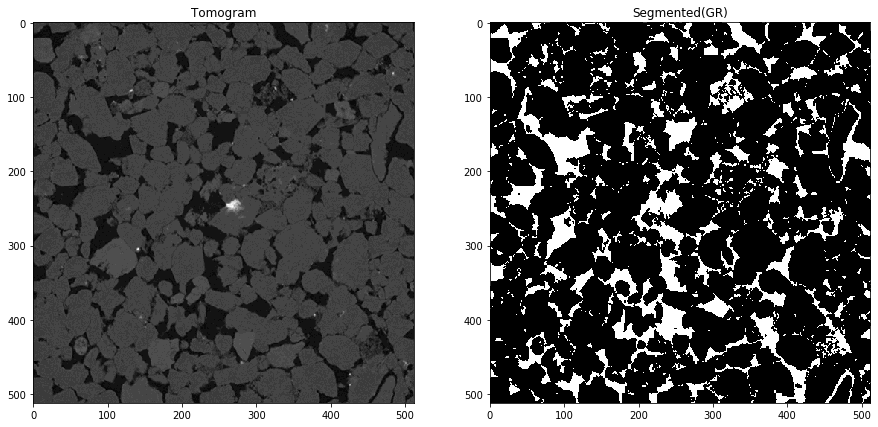

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))
ax1.imshow(X_train[4,...,0], cmap='gray')
ax1.set_title('Tomogram')
ax2.imshow((y_train[4,...,0]), cmap = 'gray')
ax2.set_title('Segmented(GR)')

Text(0.5, 1.0, 'Segmented(GR)')

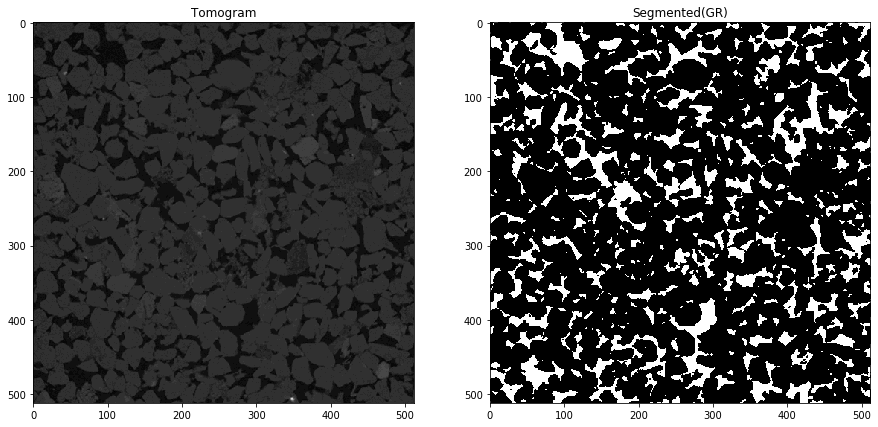

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))
ax1.imshow(X_train[5,...,0], cmap='gray')
ax1.set_title('Tomogram')
ax2.imshow((y_train[5,...,0]), cmap = 'gray')
ax2.set_title('Segmented(GR)')

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=2020)

In [12]:
print("Tomogram dimension in Training = ", X_train.shape,X_train.dtype)
print("Segmented dimension in Training  = ",y_train.shape, y_train.dtype)
print("Tomogram dimension in Testing = ",X_valid.shape, X_valid.dtype)
print("Segmented dimension in Testing = ",y_valid.shape, y_valid.dtype)

Tomogram dimension in Training =  (1920, 512, 512, 3) float32
Segmented dimension in Training  =  (1920, 512, 512, 4) int8
Tomogram dimension in Testing =  (480, 512, 512, 3) float32
Segmented dimension in Testing =  (480, 512, 512, 4) int8


In [13]:
def UResNet2D(featuremaps):
        inputs = keras.layers.Input(shape=(image_dims[0], image_dims[1], 3))

        conv1 = keras.layers.Conv2D(featuremaps * 1, (3, 3), padding="same")(inputs)
        conv1 = batch_Norm_Activation(conv1)
        conv1 = keras.layers.Conv2D(featuremaps * 1, (3, 3), padding="same")(conv1)
        conv1 = batch_Norm_Activation(conv1)
        pool1 = keras.layers.MaxPooling2D((2, 2))(conv1)

        conv2 = keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(pool1)
        conv22 = batch_Norm_Activation(conv2)
        shortcut= keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(conv22)
        shortcut= batch_Norm_Activation(shortcut)
        conv2 = keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(conv22)
        conv2 = batch_Norm_Activation(conv2)
        conv2 = keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(conv2)
        conv2 = batch_Norm_Activation(conv2)
        conv2 = add([shortcut, conv2])
        pool2 = keras.layers.MaxPooling2D((2, 2))(conv2)

        conv3 = keras.layers.Conv2D(featuremaps * 4, (3, 3), padding="same")(pool2)
        conv33 = batch_Norm_Activation(conv3)
        shortcut1= keras.layers.Conv2D(featuremaps * 4, (3, 3), padding="same")(conv33)
        shortcut1= batch_Norm_Activation(shortcut1)
        conv3 = keras.layers.Conv2D(featuremaps * 4, (3, 3), padding="same")(conv33)
        conv3 = batch_Norm_Activation(conv3)
        conv3 = keras.layers.Conv2D(featuremaps * 4, (3, 3), padding="same")(conv3)
        conv3 = batch_Norm_Activation(conv3)
        conv3 = add([shortcut1, conv3])
        pool3 = keras.layers.MaxPooling2D((2, 2))(conv3)
        
        
        conv4 = keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(pool3)
        conv44 = batch_Norm_Activation(conv4)
        shortcut2= keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(conv44)
        shortcut2= batch_Norm_Activation(shortcut2)
        conv4 = keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(conv44)
        conv4 = batch_Norm_Activation(conv4)
        conv4 = keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(conv4)
        conv4 = batch_Norm_Activation(conv4)
        conv4 = add([shortcut2, conv4])
        pool4 = keras.layers.MaxPooling2D((2, 2))(conv4)


        convm = keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(pool4)
        convm = batch_Norm_Activation(convm)
        shortcut3= keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(convm)
        shortcut3= batch_Norm_Activation(shortcut3)
        convm = keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(convm)
        convm = batch_Norm_Activation(convm)
        convm = keras.layers.Conv2D(featuremaps * 16, (3, 3), padding="same")(convm)
        convm = batch_Norm_Activation(convm)
        convm = add([shortcut3, convm])

        deconv4 = keras.layers.Conv2DTranspose(featuremaps * 8, (2, 2), strides=(2, 2), padding="same")(convm)
        uconv4 = keras.layers.concatenate([deconv4, conv4])
        uconv4 = keras.layers.Conv2D(featuremaps * 8, (2, 2), padding="same")(uconv4)
        uconv4 = batch_Norm_Activation(uconv4)
        shortcut4= keras.layers.Conv2D(featuremaps * 8, (3, 3), padding="same")(uconv4)
        shortcut4= batch_Norm_Activation(shortcut4)
        uconv4 = keras.layers.Conv2D(featuremaps * 8, (2, 2), padding="same")(uconv4)
        uconv4 = batch_Norm_Activation(uconv4)
        uconv4 = keras.layers.Conv2D(featuremaps * 8, (2, 2), padding="same")(uconv4)
        uconv4 = batch_Norm_Activation(uconv4)
        uconv4 = add([shortcut4, uconv4])

        deconv3 = keras.layers.Conv2DTranspose(featuremaps * 4, (2, 2), strides=(2, 2), padding="same")(uconv4)
        uconv3 = keras.layers.concatenate([deconv3, conv3])
        uconv3 = keras.layers.Conv2D(featuremaps * 4, (2, 2), padding="same")(uconv3)
        uconv3 = batch_Norm_Activation(uconv3)
        shortcut5= keras.layers.Conv2D(featuremaps * 4, (3, 3), padding="same")(uconv3)
        shortcut5= batch_Norm_Activation(shortcut5)
        uconv3 = keras.layers.Conv2D(featuremaps * 4, (2, 2), padding="same")(uconv3)
        uconv3 = batch_Norm_Activation(uconv3)
        uconv3 = keras.layers.Conv2D(featuremaps * 4, (2, 2), padding="same")(uconv3)
        uconv3 = batch_Norm_Activation(uconv3)
        uconv3 = add([shortcut5, uconv3])

        deconv2 = keras.layers.Conv2DTranspose(featuremaps * 2, (2, 2), strides=(2, 2), padding="same")(uconv3)
        uconv2 = keras.layers.concatenate([deconv2, conv2])
        uconv2 = keras.layers.Conv2D(featuremaps * 2, (2, 2), padding="same")(uconv2)
        uconv2 = batch_Norm_Activation(uconv2)
        shortcut6= keras.layers.Conv2D(featuremaps * 2, (3, 3), padding="same")(uconv2)
        shortcut6= batch_Norm_Activation(shortcut6)
        uconv2 = keras.layers.Conv2D(featuremaps * 2, (2, 2), padding="same")(uconv2)
        uconv2 = batch_Norm_Activation(uconv2)
        uconv2 = keras.layers.Conv2D(featuremaps * 2, (2, 2), padding="same")(uconv2)
        uconv2 = batch_Norm_Activation(uconv2)
        uconv2 = add([shortcut6, uconv2])
        

        deconv1 = keras.layers.Conv2DTranspose(featuremaps * 1, (2, 2), strides=(2, 2), padding="same")(uconv2)
        uconv1 = keras.layers.concatenate([deconv1, conv1])
        uconv1 = keras.layers.Conv2D(featuremaps * 1, (2, 2), padding="same")(uconv1)
        uconv1 = batch_Norm_Activation(uconv1)
        shortcut7= keras.layers.Conv2D(featuremaps * 1, (3, 3), padding="same")(uconv1)
        shortcut7= batch_Norm_Activation(shortcut7)
        uconv1 = keras.layers.Conv2D(featuremaps * 1, (2, 2), padding="same")(uconv1)
        uconv1 = batch_Norm_Activation(uconv1)
        uconv1 = keras.layers.Conv2D(featuremaps * 1, (2, 2), padding="same")(uconv1)
        uconv1 = batch_Norm_Activation(uconv1)
        uconv1 = add([shortcut7, uconv1])


        output_layer = keras.layers.Conv2D(4, (1,1), padding="same", activation= 'softmax')(uconv1)
        model = keras.models.Model(inputs,output_layer)
        
        return model
def batch_Norm_Activation(x, BN=False): ## To Turn off Batch Normalization, Change BN to False >
    if BN == True:
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)
    else:
        x= keras.layers.Activation("relu")(x)
    return x


In [14]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, verbose=1),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model-myresUnet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [15]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
#     model = ResUNet(512,512)
    model = UResNet2D(64)
    metrics=[ 'accuracy', iou_loss,build_iou_for(label=0), build_iou_for(label=1),build_iou_for(label=2),build_iou_for(label=3),build_iou_for(label=4), mean_iou] 
    model.compile( loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-04), metrics=metrics[:])

model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 512, 512, 64) 0           conv2d_1[0][0]                   
_____________________________________________________________________________________________

In [16]:
from sklearn.utils.class_weight import compute_class_weight
  
def sample_weight(y):
        y_integers    = np.argmax(y, axis=3)
        class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers.flatten() )
        print(class_weights)
        d_class_weights = dict(enumerate(class_weights))
    
        sample_weight = np.zeros((np.shape(y_integers)[0])) 
        for sample in range(np.shape( sample_weight)[0] ):
            frac_0 = np.sum( y_integers[sample,:,:]==0 )/np.size(y_integers[sample,:,:])
            frac_1 = np.sum( y_integers[sample,:,:]==1 )/np.size(y_integers[sample,:,:])
            frac_2 = np.sum( y_integers[sample,:,:]==2 )/np.size(y_integers[sample,:,:])
            frac_3 = np.sum( y_integers[sample,:,:]==3 )/np.size(y_integers[sample,:,:])
    
            sample_weight[sample] = frac_0*d_class_weights[0]+frac_1*d_class_weights[1]+frac_2*d_class_weights[2]+ \
                                    frac_3*d_class_weights[3]
        return sample_weight

In [17]:
hist_model = model.fit( x=X_train, y=y_train, epochs=epochs, batch_size=batch_size,
                       validation_data = (X_valid, y_valid, sample_weight(y_valid)), verbose=1, 
                       callbacks=callbacks, 
                       sample_weight=sample_weight(y_train),
                       shuffle=True )

[ 1.17628006  4.79334128  0.34224215 51.72831244]
[ 1.1713383   4.75305833  0.34293869 50.22166256]
Train on 1920 samples, validate on 480 samples
Epoch 1/50
1920/1920 [==============================] - 386s 201ms/step - loss: 0.3049 - accuracy: 0.8900 - iou_loss: 0.5022 - iou_0: 0.2994 - iou_1: 0.0000e+00 - iou_2: 0.7773 - iou_3: 4.4420e-05 - iou_4: 1.0000 - mean_iou: 0.2692 - val_loss: 0.1918 - val_accuracy: 0.9450 - val_iou_loss: 0.6584 - val_iou_0: 0.7164 - val_iou_1: 0.0000e+00 - val_iou_2: 0.8848 - val_iou_3: 0.0000e+00 - val_iou_4: 1.0000 - val_mean_iou: 0.4003

Epoch 00001: val_loss improved from inf to 0.19180, saving model to model-myresUnet.h5
Epoch 2/50
1920/1920 [==============================] - 381s 198ms/step - loss: 0.1236 - accuracy: 0.9595 - iou_loss: 0.8176 - iou_0: 0.8142 - iou_1: 0.0310 - iou_2: 0.9169 - iou_3: 0.0000e+00 - iou_4: 1.0000 - mean_iou: 0.4405 - val_loss: 0.0928 - val_accuracy: 0.9665 - val_iou_loss: 0.8612 - val_iou_0: 0.8574 - val_iou_1: 0.1579 - va

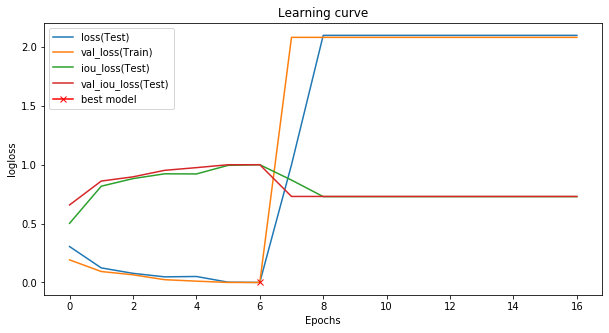

In [18]:
plt.figure(figsize=(10, 5))
plt.title("Learning curve")
plt.plot(hist_model.history["loss"], label="loss(Test)")
plt.plot(hist_model.history["val_loss"], label="val_loss(Train)")
plt.plot(hist_model.history["iou_loss"], label="iou_loss(Test)")
plt.plot(hist_model.history["val_iou_loss"], label="val_iou_loss(Test)")
plt.plot(np.argmin(hist_model.history["val_loss"]), np.min(hist_model.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("logloss")
plt.legend();

In [21]:
model.load_weights('model-myresUnet.h5')
preds_train =np.argmax(model.predict(X_train[0:10], verbose=1),axis=3)
preds_test = np.argmax(model.predict(X_valid[0:10], verbose=1),axis=3)
print(preds_train.shape,preds_test.shape)

10/10 [==============================] - 1s 61ms/step
(10, 512, 512) (10, 512, 512)


In [22]:
def plot_sample(X, y, preds, r=None):
    if r is None:
        r = random.randint(0, len(X))

    fig, ax = plt.subplots(1, 6, figsize=(35, 10))
    ax[0].imshow(X[r])
    print(X[r,...,2].shape)
    ax[0].set_title('tomogram')

    ax[2].imshow(np.argmax(y[r],axis=2))
    print(np.argmax(y[r],axis=2).shape)
    ax[2].set_title('Segmented(GR)')

    ax[1].imshow(preds[r])
    print(preds[r].shape,preds[r])
    ax[1].set_title('Prediction')
    
    ax[3].hist(X[r].ravel(), bins=30)
    ax[3].set_title('Histogram_of_original_tomogram')
    ax[4].hist(preds[r].ravel(), bins=30)
    ax[4].set_title('Histogram_of_original_segmented')
    ax[5].hist(np.argmax(y[r],axis=2).ravel(), bins=30)
    ax[5].set_title('Histogram_of_multiOtsu_segmentation')

(512, 512)
(512, 512)
(512, 512) [[0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


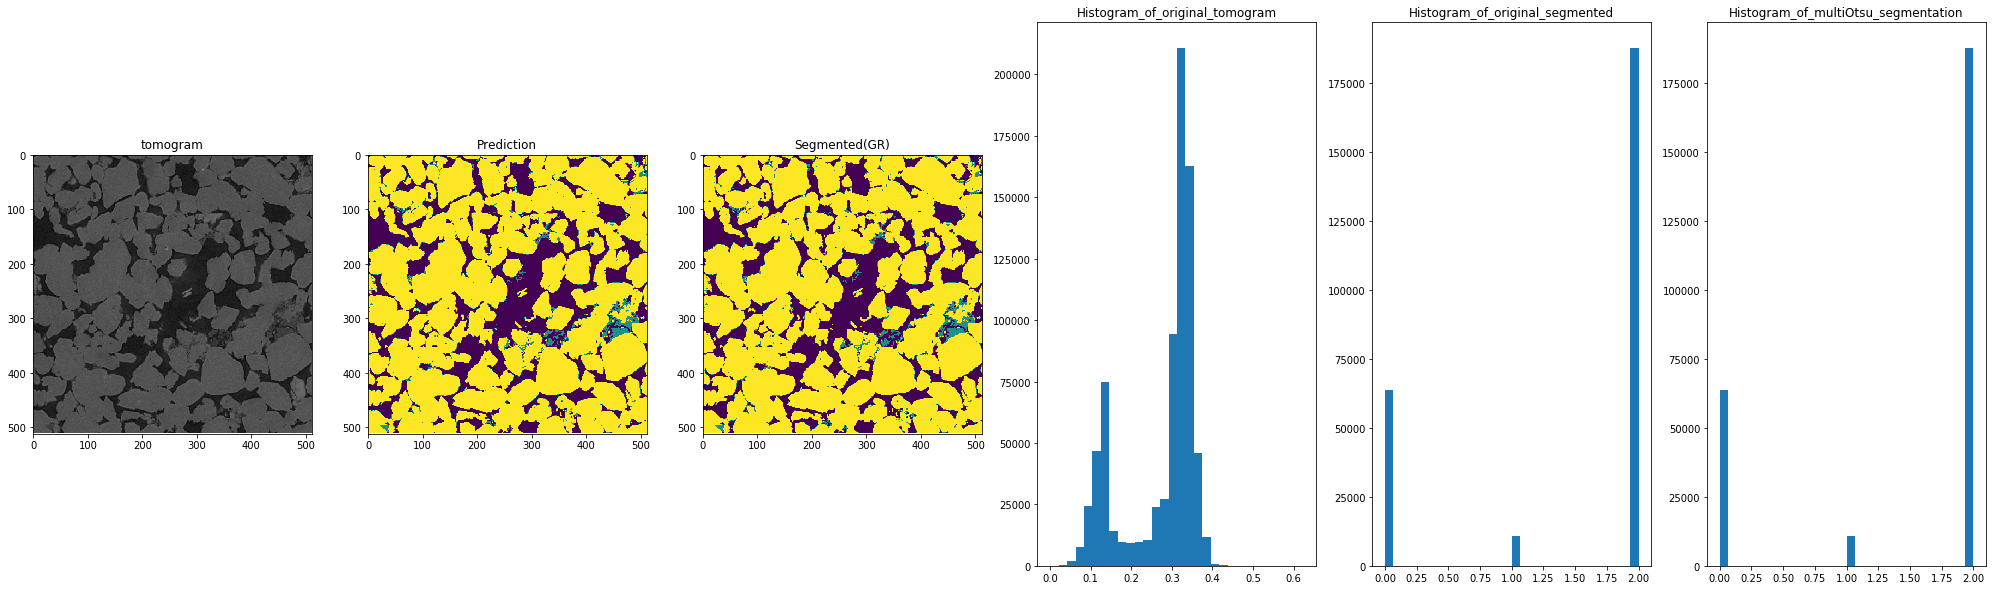

In [23]:
plot_sample(X_valid, y_valid, preds_test, r=7)

(512, 512)
(512, 512)
(512, 512) [[2 2 2 ... 1 0 0]
 [2 2 2 ... 1 0 0]
 [2 2 2 ... 1 0 0]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


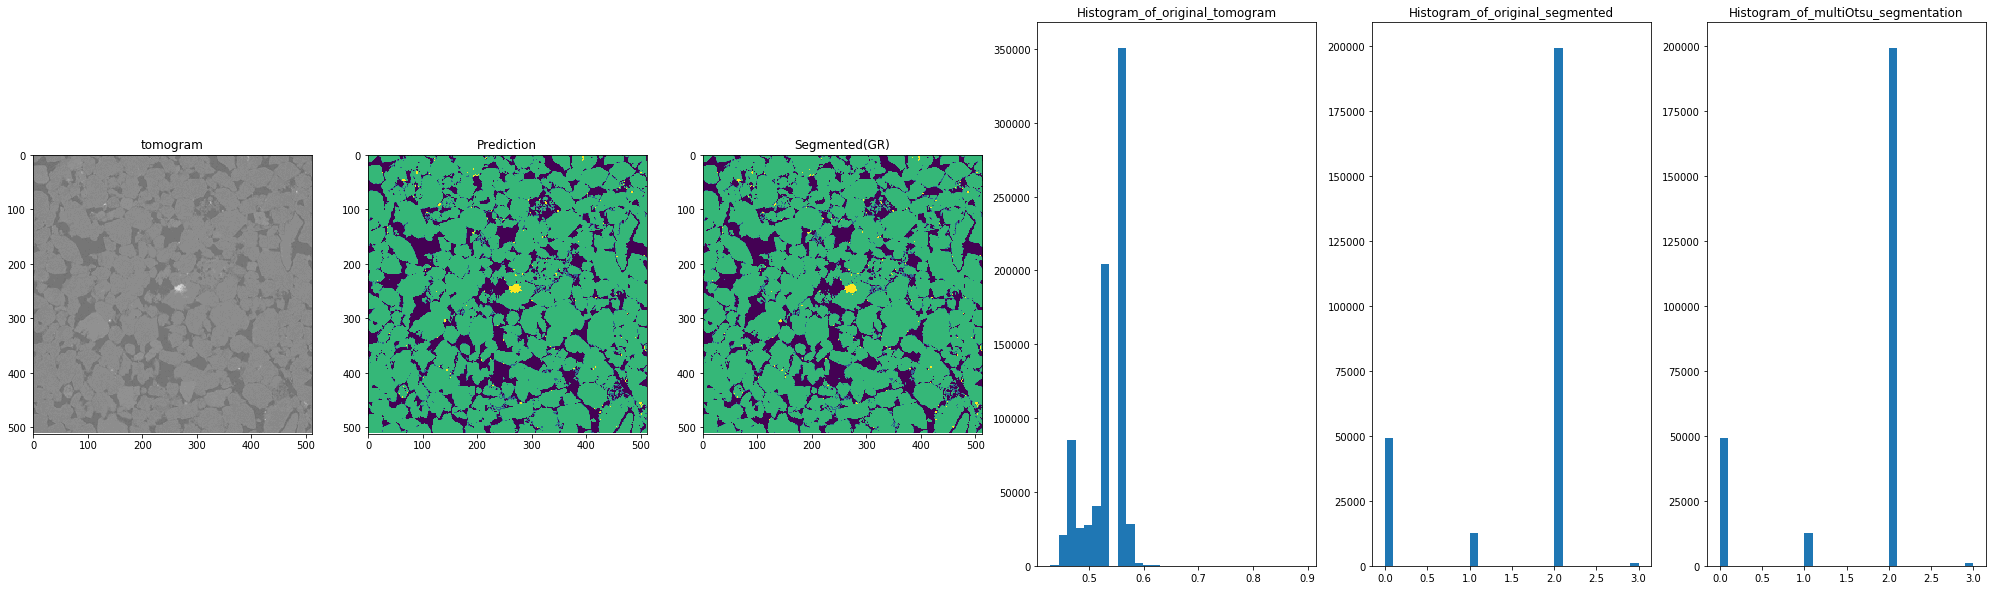

In [24]:
plot_sample(X_valid, y_valid, preds_test, r=6)

In [25]:
os.chdir("/home/ahadmomin/data/stage2_train2D/1200/tomo/")
unseen1 = cv2.imread('1200.tif')
os.chdir("/home/ahadmomin/data/stage2_train2D/1200/seg/")
label1 = cv2.imread('1200.tif',-1)
label1=  cv2.resize(label1,(512,512))
label1=to_categorical(label1).astype(np.int8)
unseen1 = cv2.resize(unseen1,(512,512))
unseen1 = (unseen1 - np.min(unseen1)) / (np.max(unseen1) - np.min(unseen1))
from medpy.filter.smoothing import anisotropic_diffusion
unseen1 = anisotropic_diffusion(unseen1,3)
kernel = np.ones((5,5), np.uint8) 
unseen1 = cv2.erode(unseen1, kernel, iterations=2) 
unseen1 = cv2.dilate(unseen1, kernel, iterations=1) 
unseen = np.expand_dims(unseen1,axis=0)
unseen = unseen.astype(np.float32)
print(unseen.shape, unseen.dtype, label1.shape, label1.dtype)

(1, 512, 512, 3) float32 (512, 512, 2) int8


/home/ahadmomin/.local/lib/python3.7/site-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/ahadmomin/.local/lib/python3.7/site-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


In [26]:
lol_test = np.argmax(model.predict(unseen, verbose=1),axis=3)
print(lol_test.shape,lol_test.dtype)

1/1 [==============================] - 1s 847ms/step
(1, 512, 512) int64


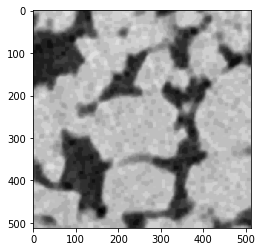

In [27]:
import scipy 
plt.imshow(unseen1)

(array([5.37110e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.23820e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.85899e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.52000e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. ]),
 <a list of 30 Patch objects>)

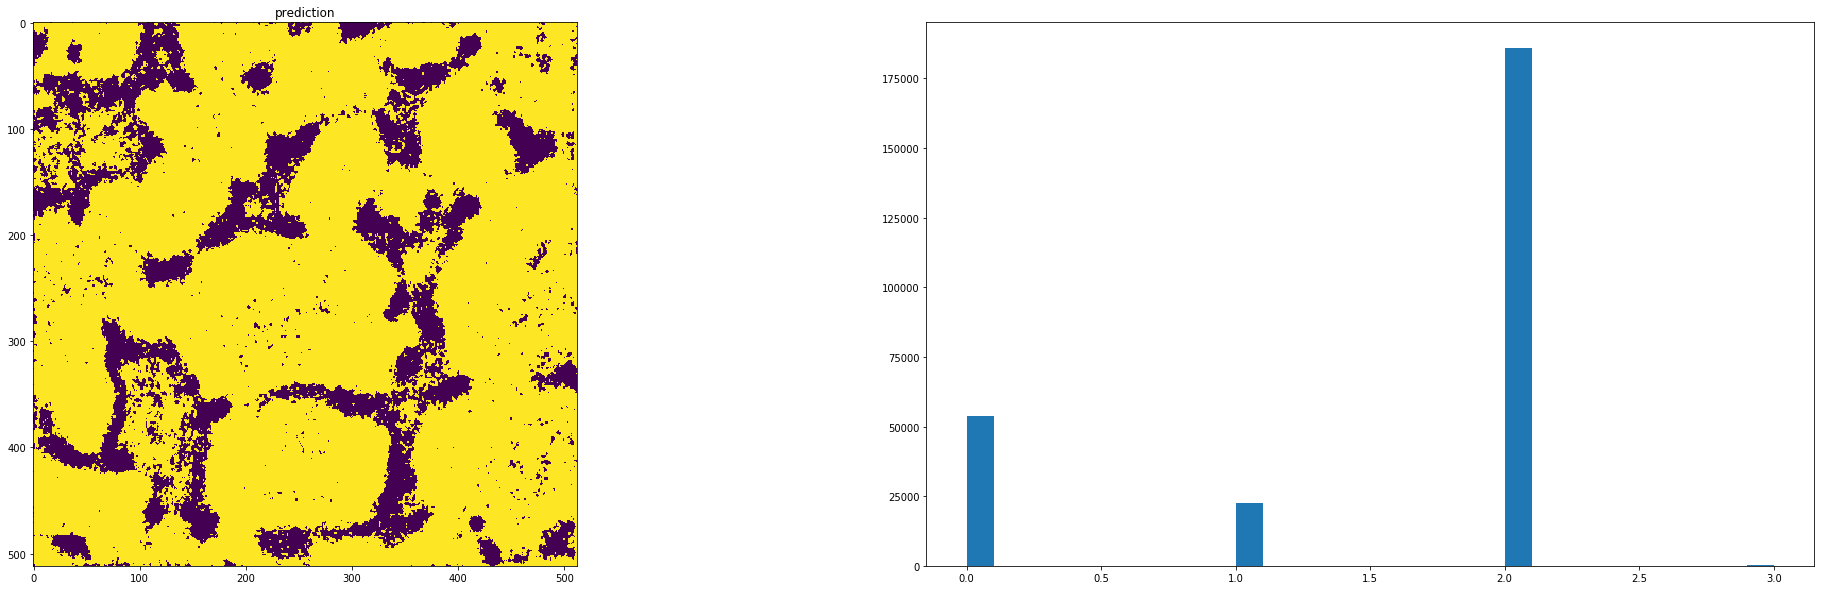

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(35, 10))
ax[0].imshow(np.squeeze(lol_test,axis=0)>0)
ax[0].set_title('prediction')
ax[1].hist(np.squeeze(lol_test,axis=0).ravel(), bins=30)


1/1 [==============================] - 0s 92ms/step


(array([ 58256.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,   4057.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0., 199831.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        , 1.06666667, 1.13333333, 1.2       , 1.26666667,
        1.33333333, 1.4       , 1.46666667, 1.53333333, 1.6       ,
        1.66666667, 1.73333333, 1.8       , 1.86666667, 1.93333333,
        2.        ]),
 <a list of 30 Patch objects>)

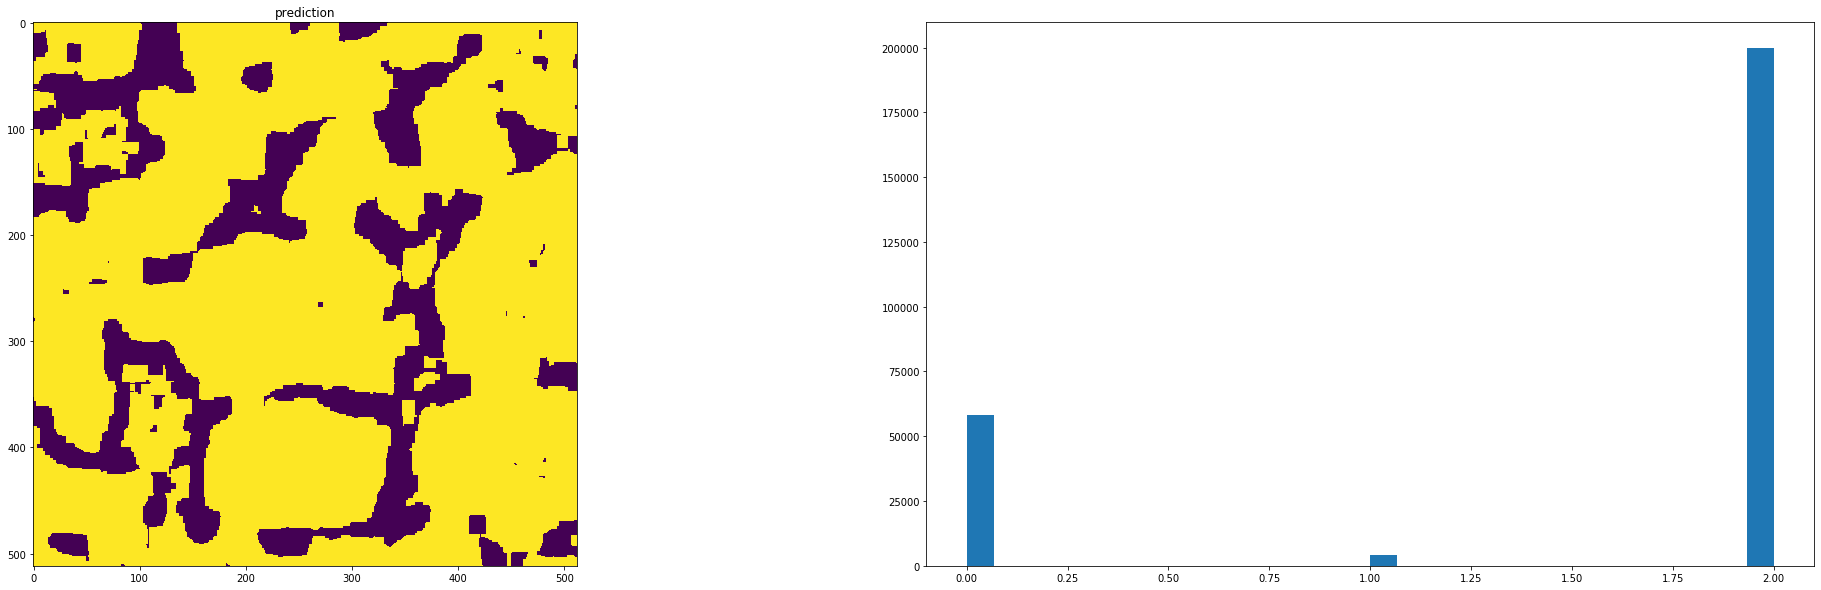

In [29]:
lol_test = model.predict(unseen, verbose=1)
lol_test=np.squeeze(lol_test,axis=0)
# lol_test=np.expand_dims(lol_test,axis=2)
lol_test = cv2.erode(lol_test, kernel, iterations=2) 
lol_test = cv2.dilate(lol_test, kernel, iterations=3) 
fig, ax = plt.subplots(1, 2, figsize=(35, 10))
ax[0].imshow(np.argmax(lol_test, axis=2)>0)
ax[0].set_title('prediction')
ax[1].hist(np.argmax(lol_test, axis=2).ravel(), bins=30)

(array([ 58114.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0., 204030.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <a list of 30 Patch objects>)

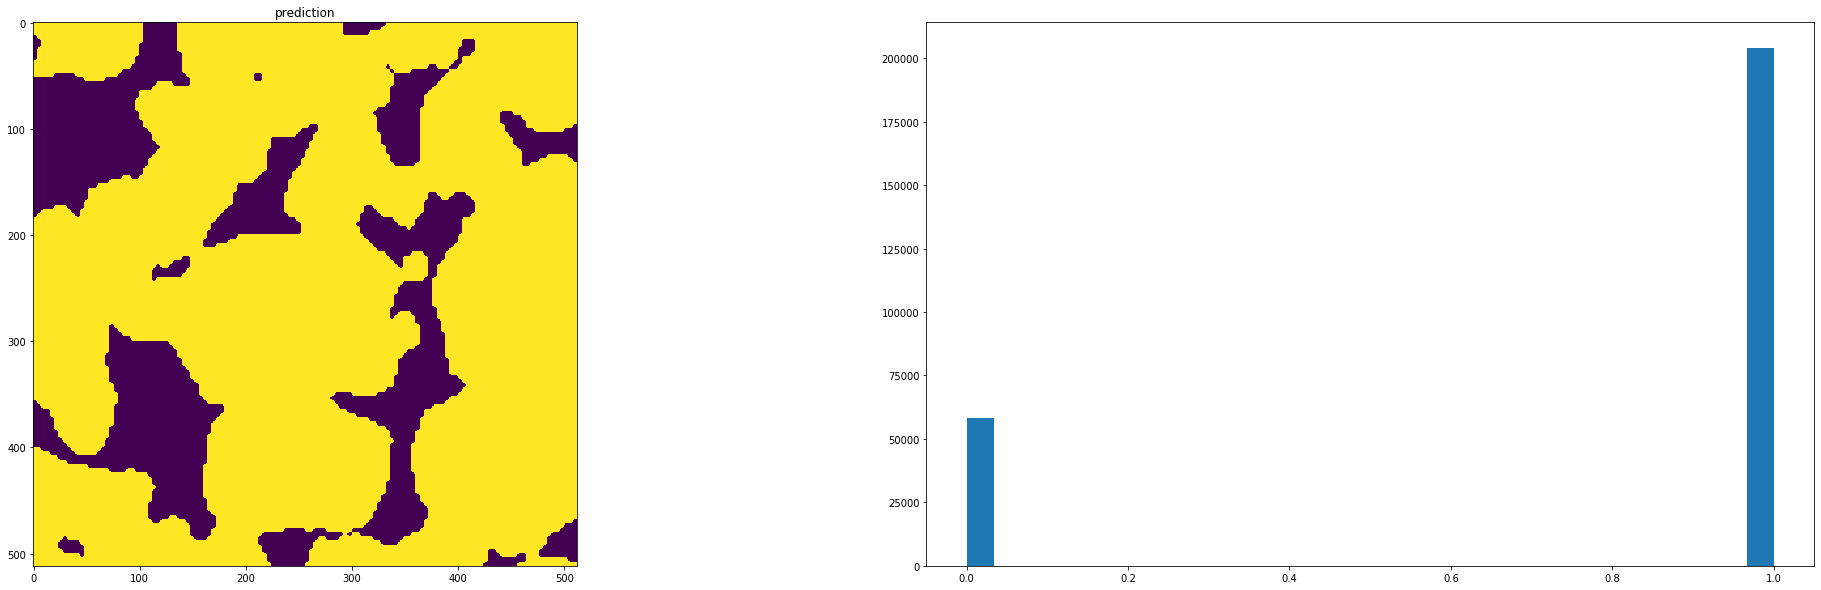

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(35, 10))
ax[0].imshow(np.argmax(label1*-1,axis=2))
ax[0].set_title('prediction')
ax[1].hist(np.argmax(label1*-1,axis=2).ravel(), bins=30)

In [37]:
os.chdir("/home/ahadmomin/unseen/")
unseen1 = cv2.imread('Anisotropic_diffusion.tif')
label1 = cv2.imread('segmented.tif',-1)
label1=  cv2.resize(label1,(512,512))
label1=to_categorical(label1).astype(np.int8)
unseen1 = cv2.resize(unseen1,(512,512))
unseen1 = (unseen1 - np.min(unseen1)) / (np.max(unseen1) - np.min(unseen1))
unseen = np.expand_dims(unseen1,axis=0)
unseen = unseen.astype(np.float32)
print(unseen.shape, unseen.dtype, label1.shape, label1.dtype)

(1, 512, 512, 3) float32 (512, 512, 256) int8


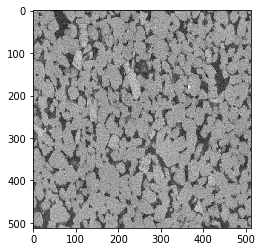

In [38]:
plt.imshow(unseen1)

In [39]:
lol_test = np.argmax(model.predict(unseen, verbose=1),axis=3)
print(lol_test.shape,lol_test.dtype)

1/1 [==============================] - 0s 93ms/step
(1, 512, 512) int64


(array([5.97440e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.30030e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.89292e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.05000e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. ]),
 <a list of 30 Patch objects>)

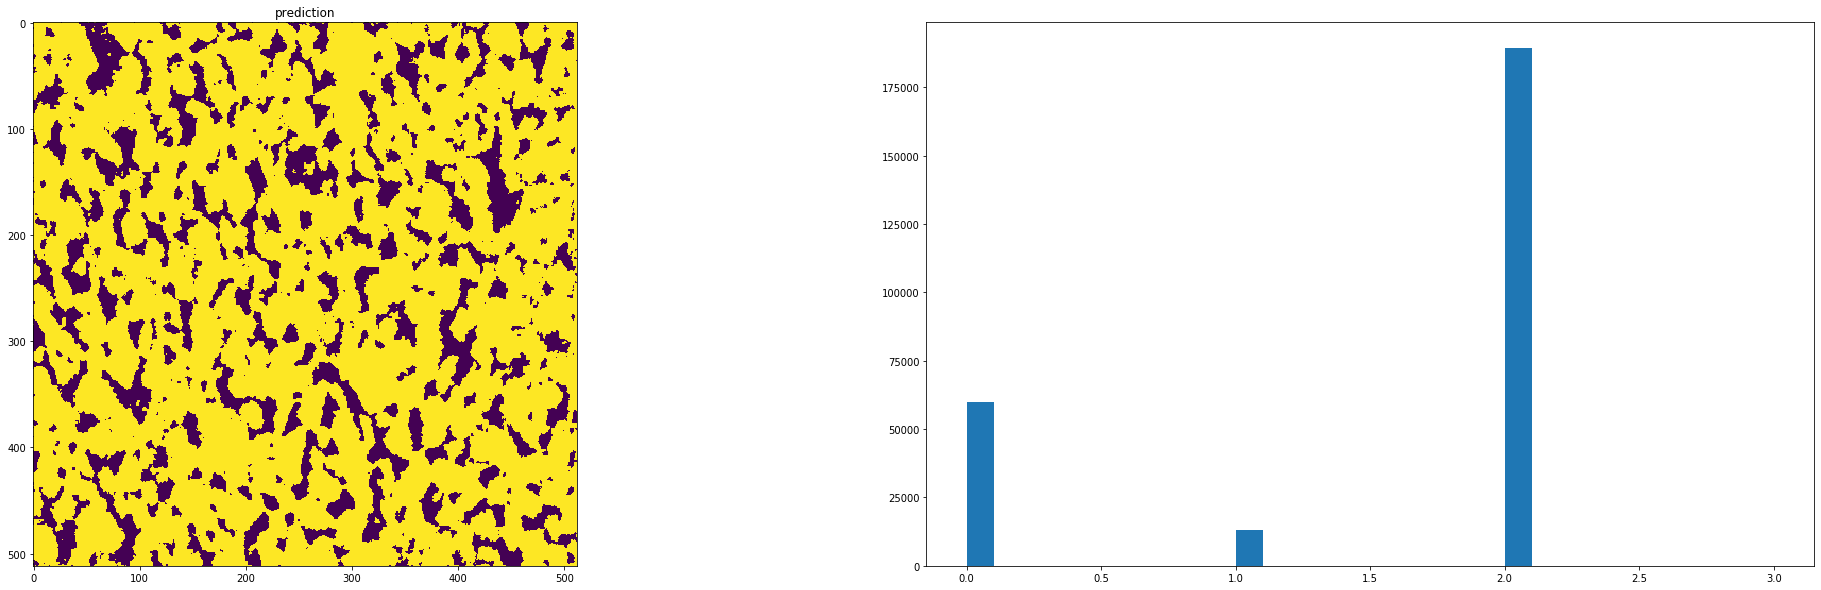

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(35, 10))
ax[0].imshow(np.squeeze(lol_test,axis=0)>0)
ax[0].set_title('prediction')
ax[1].hist(lol_test.ravel(), bins=30)